In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Define the model
class LappedTransformCNN(nn.Module):
    def __init__(self):
        super(LappedTransformCNN, self).__init__()
        # Define the convolutional layer for the transform
        # These kernels act as the transform filters
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=16, stride=8, padding=4, bias=False)
        # Define the inverse convolutional layer for reconstruction
        # These kernels act as the inverse transform filters
        self.conv2 = nn.ConvTranspose2d(in_channels=48, out_channels=3, kernel_size=16, stride=8, padding=4, bias=False)

    def forward(self, x):
        x = self.conv1(x)  # Apply the transform filters
        x = self.conv2(x)  # Apply the inverse transform filters to reconstruct the image
        return x

model = LappedTransformCNN()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data  # inputs are the original images, targets are also the original images

        optimizer.zero_grad()

        outputs = model(inputs)  # Model's attempt to reconstruct the inputs
        loss = criterion(outputs, inputs)  # Loss is computed between outputs and inputs
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print('Finished Training')

# Evaluate the model
model.eval()
total_loss = 0.0
with torch.no_grad():
    for data in testloader:
        inputs, _ = data  # inputs are the original images, targets are also the original images
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Loss is computed between outputs and inputs
        total_loss += loss.item()

print(f'Average test loss: {total_loss / len(testloader):.3f}')

# Save the model
torch.save(model.state_dict(), 'lapped_transform_cnn.pth')


Files already downloaded and verified
Files already downloaded and verified
[1, 100] loss: 0.061
[1, 200] loss: 0.020
[1, 300] loss: 0.013
[2, 100] loss: 0.008
[2, 200] loss: 0.007
[2, 300] loss: 0.006
[3, 100] loss: 0.005
[3, 200] loss: 0.004
[3, 300] loss: 0.004
[4, 100] loss: 0.003
[4, 200] loss: 0.003
[4, 300] loss: 0.003
[5, 100] loss: 0.003
[5, 200] loss: 0.003
[5, 300] loss: 0.003
[6, 100] loss: 0.002
[6, 200] loss: 0.002
[6, 300] loss: 0.002
[7, 100] loss: 0.002
[7, 200] loss: 0.002
[7, 300] loss: 0.002
[8, 100] loss: 0.002
[8, 200] loss: 0.002
[8, 300] loss: 0.002
[9, 100] loss: 0.002
[9, 200] loss: 0.002
[9, 300] loss: 0.002
[10, 100] loss: 0.002
[10, 200] loss: 0.002
[10, 300] loss: 0.002
[11, 100] loss: 0.002
[11, 200] loss: 0.002
[11, 300] loss: 0.002
[12, 100] loss: 0.002
[12, 200] loss: 0.002
[12, 300] loss: 0.002
[13, 100] loss: 0.002
[13, 200] loss: 0.002
[13, 300] loss: 0.002
[14, 100] loss: 0.002
[14, 200] loss: 0.002
[14, 300] loss: 0.002
[15, 100] loss: 0.002
[15, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


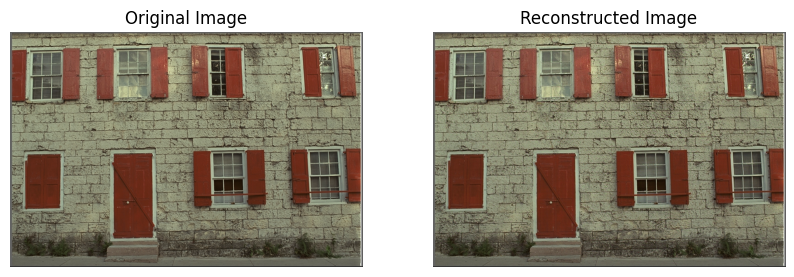

Original image size: 4718592 bytes
Compressed image size: 1179648 bytes
Compression ratio: 4.0


In [3]:
def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(tensor.device)  # Reshape mean to match tensor shape
    std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(tensor.device)   # Reshape std to match tensor shape
    tensor = tensor * std + mean  # Denormalize
    return tensor

# Quantize function
def quantize(tensor, num_levels):
    min_val = tensor.min()
    max_val = tensor.max()
    scale = (max_val - min_val) / (num_levels - 1)
    quantized = torch.round((tensor - min_val) / scale)
    return quantized, scale, min_val

# Dequantize function
def dequantize(quantized, scale, min_val):
    dequantized = quantized * scale + min_val
    return dequantized

# Full Compression Function
def compress_image(image, model, num_levels):
    # Transform the image
    with torch.no_grad():
        transformed_image = model.conv1(image)
    # Quantize the transformed image
    quantized_image, scale, min_val = quantize(transformed_image, num_levels)
    # Flatten and convert to byte stream
    flat_quantized = quantized_image.flatten().cpu().numpy()
    byte_stream = flat_quantized.tobytes()
    return byte_stream, quantized_image.shape, scale, min_val

# Full Decompression Function
def decompress_image(byte_stream, shape, scale, min_val, model):
    # Convert byte stream back to numpy array
    flat_quantized = np.frombuffer(byte_stream, dtype=np.float32)
    quantized_image = torch.tensor(flat_quantized).view(shape).to(model.conv1.weight.device)
    # Dequantize (inverse of quantization)
    dequantized_image = dequantize(quantized_image, scale, min_val)
    # Inverse transform
    with torch.no_grad():
        reconstructed_image = model.conv2(dequantized_image)
    return reconstructed_image

# Load an external image using OpenCV
example_image = cv.imread('./1.png')
example_image = cv.cvtColor(example_image, cv.COLOR_BGR2RGB)
example_image = torch.from_numpy(example_image).permute(2, 0, 1).unsqueeze(0).float() / 255.0
example_image = (example_image - 0.5) / 0.5  # Normalize the image

# Compress and decompress the example image
model = LappedTransformCNN()
model.load_state_dict(torch.load('lapped_transform_cnn.pth'))
model.eval()

compressed_byte_stream, shape, scale, min_val = compress_image(example_image, model, num_levels=256)
reconstructed_image = decompress_image(compressed_byte_stream, shape, scale, min_val, model=model)

# Convert tensors to numpy arrays for visualization
original_image_np = denormalize(example_image).squeeze().permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = denormalize(reconstructed_image).squeeze().permute(1, 2, 0).cpu().numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()

# Check the sizes
original_image_size = example_image.nelement() * example_image.element_size()
compressed_image_size = len(compressed_byte_stream)
compression_ratio = original_image_size / compressed_image_size

print(f'Original image size: {original_image_size} bytes')
print(f'Compressed image size: {compressed_image_size} bytes')
print(f'Compression ratio: {compression_ratio}')